In [15]:
%pip install seaborn
%pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


^C
Note: you may need to restart the kernel to use updated packages.


     --------------------------------------- 15.5/15.5 MB 10.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# helper functions

In [2]:
def convertColumnNameToCammelCase(dataFrame:pd.DataFrame, inplace:bool=False):
    '''
        convert column name to cammelCase
        Return None if inplace==True
            DataFrame with column names in cammelCase
    '''
    columnNameMapping = dict()
    for initColumnName in dataFrame.columns:
        initColumnName: str
        if len(initColumnName.split(' ')) == 2:
            firstPart = initColumnName.split(' ')[0].lower()
            secondPart = initColumnName.split(' ')[1].lower().capitalize()
            columnNameMapping[initColumnName] = firstPart+secondPart
        else:
            columnNameMapping[initColumnName] = initColumnName.lower()
    newDfOrNone = dataFrame.rename(columns=columnNameMapping, inplace=inplace)
    return newDfOrNone


# Data preprocessing

In [3]:
# read csv and convert date time correct format
transactionDataframe = pd.read_csv('../data/transaction_cleaned.csv')
# replace column Name with cammelCase
convertColumnNameToCammelCase(transactionDataframe, True)

transactionDataframe['transactionDate'] = pd.to_datetime(transactionDataframe['transactionDate'], dayfirst=True)
# add day of year column 1 to 366
transactionDataframe['dayOfYear'] = transactionDataframe['transactionDate'].dt.dayofyear
# add day of week: 1to7 1: monday, 2: tuesday...
transactionDataframe['dayOfWeek'] = transactionDataframe['transactionDate'].dt.dayofweek + 1 
# week of the year 1 to 53
transactionDataframe['weekOfYear'] = transactionDataframe['transactionDate'].dt.isocalendar().week

# add isCredit: reference: https://stackoverflow.com/questions/71000585/create-a-new-column-in-pandas-dataframe-based-on-the-nan-values-in-another-col
transactionDataframe['isCredit'] = transactionDataframe['creditAmount'].isna()==False
# add transaction Amount based on isCredit, if isCredit is true, use Credit Amount, else use Debit Amount
transactionDataframe['transactionAmount'] = transactionDataframe.apply(lambda row: row.creditAmount if row['isCredit'] else row.debitAmount, axis=1)
transactionDataframe['categoryNumerical'] = transactionDataframe['category'].replace(set(transactionDataframe['category']), [ i for i in range(len(set(transactionDataframe['category'])))])

In [16]:
transactionDataframe

,unnamed:0,transactionNumber,transactionDate,transactionType,transactionDescription,debitAmount,creditAmount,balance,category,locationCity,locationCountry,dayOfYear,dayOfWeek,weekOfYear,isCredit,transactionAmount,categoryNumerical
0,0,1,2022-07-25,BP,SAVE THE CHANGE,3.11,NaN,541.43,Savings,Nottingham,Uk,206,1,30,False,3.11,5
1,1,2,2022-07-25,DEB,LIDL GB NOTTINGHA,15.02,NaN,544.54,Groceries,Nottingham,Uk,206,1,30,False,15.02,19
2,2,3,2022-07-25,DEB,NON-GBP PURCH FEE,0.50,NaN,559.56,Others,Nottingham,Uk,206,1,30,False,0.50,13
3,3,4,2022-07-25,DEB,NON-GBP TRANS FEE,0.37,NaN,560.06,Others,Nottingham,Uk,206,1,30,False,0.37,13
4,4,5,2022-07-25,DEB,TRAVELIUM LLC,12.59,NaN,560.43,NaN,NaN,NaN,206,1,30,False,12.59,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,6562,6563,2015-07-28,DEB,Amazon Svcs Europe,5.49,NaN,7187.57,Amazon,Swansea,Uk,209,2,31,False,5.49,7
6563,6563,6564,2015-07-28,BP,SAVE THE CHANGE,1.10,NaN,7193.06,Savings,Swansea,Uk,209,2,31,False,1.10,5
6564,6564,6565,2015-07-27,DEB,Amazon UK Marketpl,6.39,NaN,7194.16,Amazon,Swansea,Uk,208,1,31,False,6.39,7
6565,6565,6566,2015-07-27,DEB,JS ONLINE GROCERY,316.51,NaN,7200.55,Groceries,Swansea,Uk,208,1,31,False,316.51,19


# apply k-means on transaction amount and dayofyear

## function version

In [43]:
import plotly.express as px
# 
def showKmean(attr1, attr2, numberOfCluster, chart, dataframe):
    '''
        run k-mean algorithm, plot the two attributes.
        Use scatter plot if chart = 'scatter'
        Use parallel coordinated plot if chart = 'pcp
    '''
    x1 = dataframe[attr1].to_numpy()
    x2 = dataframe[attr2].to_numpy()
    X = np.dstack((x1,x2))[0]
    kmeans = KMeans(numberOfCluster, random_state=0).fit(X)
    
    # reference https://www.statology.org/seaborn-legend-position/
    if chart=='scatter':
        def showKmeanScatter(yScale):
            sb.scatterplot(x=transactionDataframe['dayOfYear'], y=transactionDataframe['transactionAmount'], hue=kmeans.labels_, size=1, linewidth=0)
            plt.yscale(yScale)
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        return showKmeanScatter
    elif chart=='pcp':
        def showKmeanPCP(colourScale):
            copiedDataFrame = transactionDataframe.copy()
            copiedDataFrame['cluster'] = kmeans.labels_
            fig = px.parallel_coordinates(copiedDataFrame, color=colourScale)
            fig.show()
        return showKmeanPCP

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



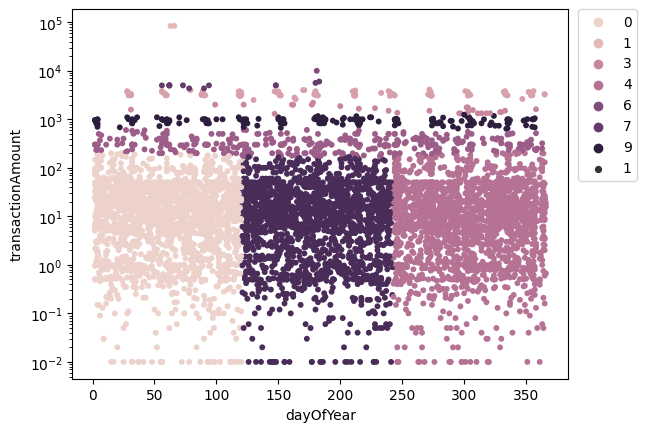

In [41]:
showKmean(attr1='transactionAmount', attr2='dayOfYear', numberOfCluster=10, chart='scatter',dataframe=transactionDataframe)('log')

In [44]:
showKmean(attr1='transactionAmount', attr2='dayOfYear', numberOfCluster=10, chart='pcp',dataframe=transactionDataframe)('cluster')

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [17]:
# assert the number of na in transactin amount and day of year is 0
assert(transactionDataframe.transactionAmount.isna().sum()==0)
assert(transactionDataframe.dayOfYear.isna().sum()==0)

### put data into numpy array

In [18]:
x1 = transactionDataframe.transactionAmount.to_numpy() # amount
x2 = transactionDataframe.dayOfYear.to_numpy() # day of year
x3 = transactionDataframe.weekOfYear.to_numpy() # week of year
x4 = transactionDataframe.dayOfWeek.to_numpy() # day of week
X = np.dstack((x1,x2,x3,x4))[0]

In [19]:
X

array([[3.11, 206, 30, 1],
       [15.02, 206, 30, 1],
       [0.5, 206, 30, 1],
       ...,
       [6.39, 208, 31, 1],
       [316.51, 208, 31, 1],
       [1000.0, 208, 31, 1]], dtype=object)

### run k-mean

In [20]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# add k-means category into the dataframe
transactionDataframe['cluster'] = kmeans.labels_

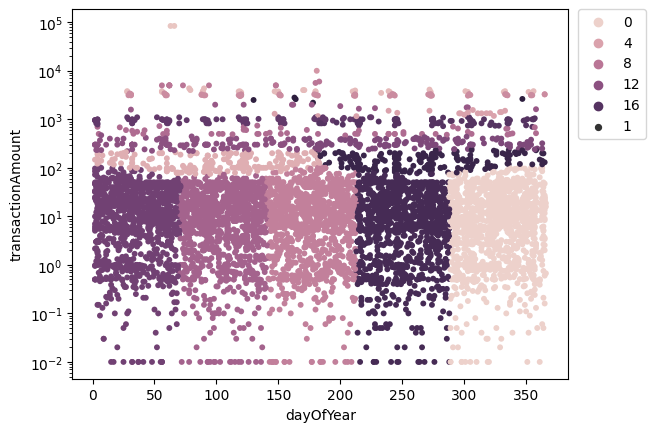

In [28]:
# reference https://www.statology.org/seaborn-legend-position/
sb.scatterplot(x=transactionDataframe['dayOfYear'], y=transactionDataframe['transactionAmount'], hue=kmeans.labels_, size=1, linewidth=0)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# plot use pcp

In [35]:
import plotly.express as px

fig = px.parallel_coordinates(transactionDataframe, color='categoryNumerical')
fig.show()

In [46]:
%pip install dash

  Obtaining dependency information for dash from https://files.pythonhosted.org/packages/35/b8/28850cc6bedd9c39ac05e520596d102ec1139635caabf9d33d9c928c9938/dash-2.11.1-py3-none-any.whl.metadata
  Using cached dash_html_components-2.0.0-py3-none-any.whl (4.1 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl (3.8 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl (3.9 kB)
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Using cached retrying-1.3.4-py3-none-any.whl (11 kB)
  Using cached ansi2html-1.8.0-py3-none-any.whl (16 kB)
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/5c/f2/f3faa20684729d3910af2ee142e30432c7a46a817eadeeab87366ed87bbb/charset_normalizer-3.2.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for urllib3<3,>=1.21.1 from 

In [47]:

from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder_unfiltered.csv')

app = Dash(__name__)

app.layout = html.Div([
    html.H1(children='Title of Dash App', style={'textAlign':'center'}),
    dcc.Dropdown(df.country.unique(), 'Canada', id='dropdown-selection'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = df[df.country==value]
    return px.line(dff, x='year', y='pop')

if __name__ == '__main__':
    app.run(debug=True)

: 